In [1]:
import numpy as np
import cv2
import glob
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
car_samples = glob.glob('./vehicles/**/*.png')
noncar_samples = glob.glob('./non-vehicles/**/*.png')
print(len(car_samples))
print(len(noncar_samples))

8792
8968


In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell,pix_per_cell), cells_per_block=(cell_per_block,cell_per_block), transform_sqrt=False,visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell,pix_per_cell), cells_per_block=(cell_per_block,cell_per_block), transform_sqrt=False,visualise=vis, feature_vector=feature_vec)
        return features
    


In [27]:
car_sample = mpimg.imread(car_samples[0])
_,car_d = get_hog_features(car_sample[:,:,2],9,8,2,vis=True,feature_vec=True)
noncar_sample = mpimg.imread(noncar_samples[0])
_,noncar_d = get_hog_features(noncar_sample[:,:,2],9,8,2,vis=True,feature_vec=True)

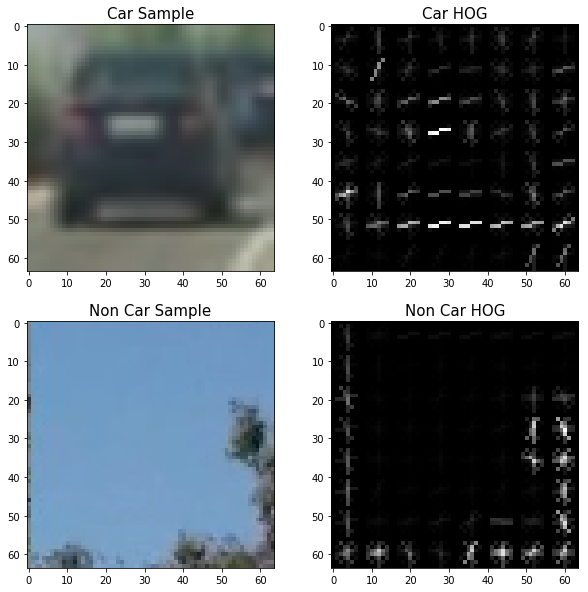

In [28]:
f,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,10))
ax1.imshow(car_sample)
ax1.set_title('Car Sample',fontsize=15)
ax2.imshow(car_d, cmap='gray')
ax2.set_title('Car HOG',fontsize=15)
ax3.imshow(noncar_sample)
ax3.set_title('Non Car Sample', fontsize=15)
ax4.imshow(noncar_d, cmap='gray')
ax4.set_title('Non Car HOG', fontsize=15)

In [6]:
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [7]:
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(car_samples, cspace=colorspace, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
noncar_features = extract_features(noncar_samples, cspace=colorspace, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, noncar_features)).astype(np.float64)
#X_scaler = StandardScaler().fit(X)
#scaled_X = X_scaler.transform(X)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))


57.33 Seconds to extract HOG features...


In [8]:
random = np.random.randint(0,100)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=random)
print('Training and Testing Data Separated\n')

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Training and Testing Data Separated

Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188


In [9]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

1.03 Seconds to train SVC...
Test Accuracy of SVC =  0.9814
My SVC predicts:  [ 0.  1.  1.  1.  0.  1.  1.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  1.  1.  0.  1.  1.  1.  0.  0.]
0.00161 Seconds to predict 10 labels with SVC


In [10]:
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, orient, 
              pix_per_cell, cell_per_block, show_all_rectangles=False):
    rectangles = []
    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

In [11]:
def draw_boxes(img, bboxes, color=(0, 255, 0), thick=2):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [31]:
test_image = mpimg.imread('./test_images/test6.jpg')
ystart = 400
ystop = 656
scale = 1.5
orient = 11
pix_per_cell = 16
cell_per_block = 2
colorspace = 'YUV'
hog_channel = 'ALL'

rectangles = find_cars(test_image, ystart, ystop, scale, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block)

print(len(rectangles), 'rectangles found in image')

5 rectangles found in image


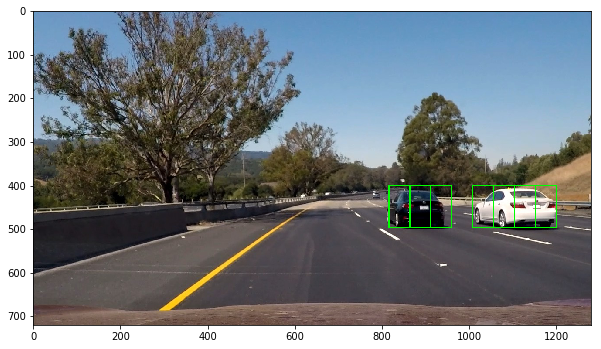

In [32]:
drawn_image = draw_boxes(test_image, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(drawn_image)

Number of boxes:  194


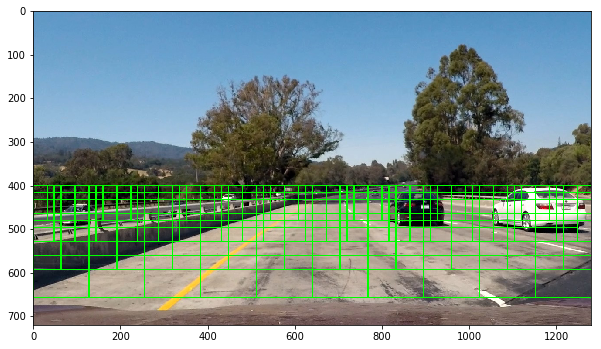

In [14]:
rectangles = []

ystart = 400
ystop = 464
scale = 1.0
rectangles.append(find_cars(test_image, ystart, ystop, scale, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, show_all_rectangles=True))
ystart = 416
ystop = 480
scale = 1.0
rectangles.append(find_cars(test_image, ystart, ystop, scale, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, show_all_rectangles=True))
ystart = 400
ystop = 496
scale = 1.5
rectangles.append(find_cars(test_image, ystart, ystop, scale, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, show_all_rectangles=True))
ystart = 432
ystop = 528
scale = 1.5
rectangles.append(find_cars(test_image, ystart, ystop, scale, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, show_all_rectangles=True))
ystart = 400
ystop = 600
scale = 2.0
rectangles.append(find_cars(test_image, ystart, ystop, scale, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, show_all_rectangles=True))
ystart = 432
ystop = 600
scale = 2.0
rectangles.append(find_cars(test_image, ystart, ystop, scale, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, show_all_rectangles=True))
ystart = 400
ystop = 700
scale = 4.0
rectangles.append(find_cars(test_image, ystart, ystop, scale, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, show_all_rectangles=True))
ystart = 464
ystop = 700
scale = 4.0
rectangles.append(find_cars(test_image, ystart, ystop, scale, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, show_all_rectangles=True))


rectangles = [item for sublist in rectangles for item in sublist]

drawn_image = draw_boxes(test_image, rectangles,)
plt.figure(figsize=(10,10))
plt.imshow(drawn_image)
print('Number of boxes: ', len(rectangles))

Number of boxes:  17


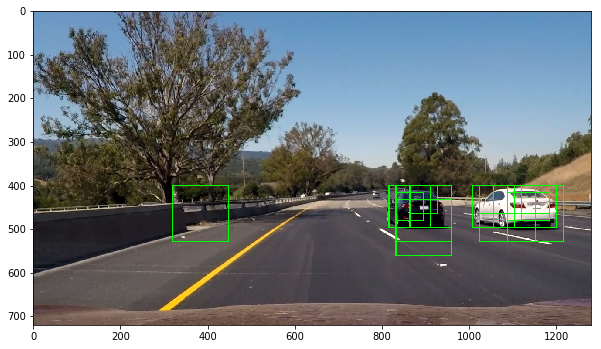

In [33]:
orient = 11
pix_per_cell = 16
cell_per_block = 2
colorspace = 'YUV'
hog_channel = 'ALL'
rectangles = []

ystart = 400
ystop = 464
scale = 1.0
rectangles.append(find_cars(test_image, ystart, ystop, scale, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block))
ystart = 416
ystop = 480
scale = 1.0
rectangles.append(find_cars(test_image, ystart, ystop, scale, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block))
ystart = 400
ystop = 496
scale = 1.5
rectangles.append(find_cars(test_image, ystart, ystop, scale, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block))
ystart = 432
ystop = 528
scale = 1.5
rectangles.append(find_cars(test_image, ystart, ystop, scale, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block))
ystart = 400
ystop = 600
scale = 2.0
rectangles.append(find_cars(test_image, ystart, ystop, scale, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block))
ystart = 432
ystop = 600
scale = 2.0
rectangles.append(find_cars(test_image, ystart, ystop, scale, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block))
ystart = 400
ystop = 700
scale = 4.0
rectangles.append(find_cars(test_image, ystart, ystop, scale, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block))
ystart = 464
ystop = 700
scale = 4.0
rectangles.append(find_cars(test_image, ystart, ystop, scale, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block))

rectangles = [item for sublist in rectangles for item in sublist]

drawn_image = draw_boxes(test_image, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(drawn_image)
print('Number of boxes: ', len(rectangles))

In [16]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

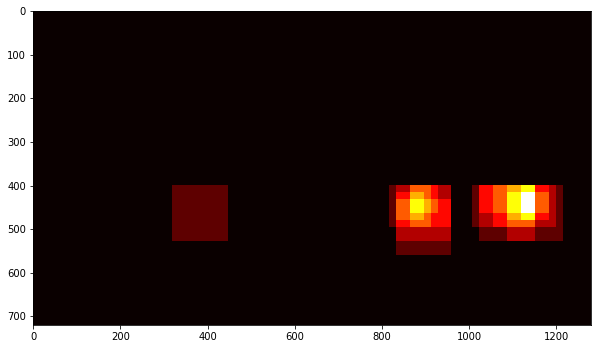

In [34]:
heatmap_image = np.zeros_like(test_image[:,:,0])
heatmap_image = add_heat(heatmap_image, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_image, cmap='hot')

In [35]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

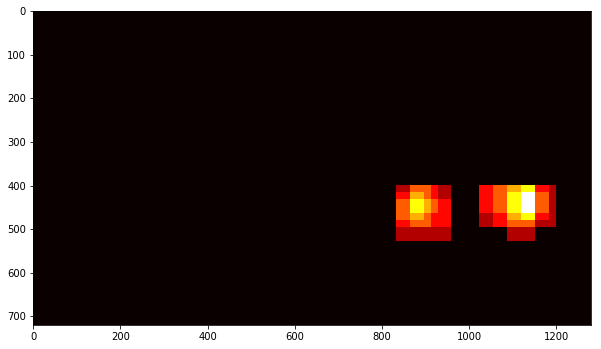

In [36]:
heatmap_image = apply_threshold(heatmap_image, 1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_image, cmap='hot')

2 cars found


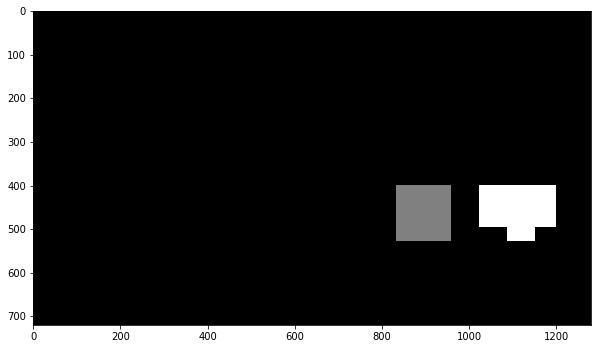

In [37]:
labels = label(heatmap_image)
plt.figure(figsize=(10,10))
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

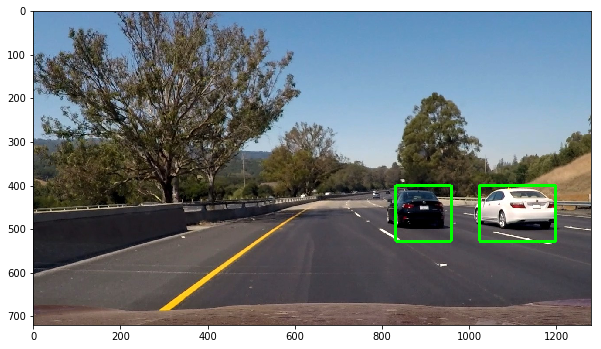

In [38]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image and final rectangles
    return img

# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(test_image), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

In [22]:
class Saver():
    def __init__(self):
        self.prev_rectangles = [] 
    def add_rectangles(self, rectangles):
        self.prev_rectangles.append(rectangles)
        if len(self.prev_rectangles) > 15:
            self.prev_rectangles = self.prev_rectangles[len(self.prev_rectangles)-15:]

In [25]:
def process_video(img):
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    colorspace = 'YUV'
    hog_channel = 'ALL'
    rectangles = []
    
    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block))
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block))
    ystart = 400
    ystop = 650
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block))
    ystart = 432
    ystop = 650
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block))
  
    rectangles = [item for sublist in rectangles for item in sublist] 
    
    if len(rectangles) > 0:
        outvideo.add_rectangles(rectangles)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for history in outvideo.prev_rectangles:
        heatmap_img = add_heat(heatmap_img, history)
    heatmap_img = apply_threshold(heatmap_img, 2 + len(outvideo.prev_rectangles)//2)
     
    labels = label(heatmap_img)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [26]:
outvideo = Saver()
test_out_file2 = 'project_video_output0.mp4'
clip_test2 = VideoFileClip('project_video.mp4')
clip_test_out2 = clip_test2.fl_image(process_video)
%time clip_test_out2.write_videofile(test_out_file2, audio=False)

[MoviePy] >>>> Building video project_video_output0.mp4
[MoviePy] Writing video project_video_output0.mp4


100%|█████████▉| 1260/1261 [06:01<00:00,  3.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output0.mp4 

CPU times: user 5min 22s, sys: 39.4 s, total: 6min 2s
Wall time: 6min 2s
